In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from itertools import product
from sklearn.model_selection import train_test_split
from pathlib import Path
import random
from tqdm import tqdm
import xml.etree.ElementTree as ET
import cv2
from torchvision.transforms import Compose
from torchvision.transforms import ToTensor




In [2]:
from torch.utils.data import Dataset
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

class thyroidDataset(Dataset):
    def __init__(self, split):
        self.all_data = []
        self.compositions = {'Unknown':0, 'cystic':1,
                             'predominantly solid':2,
                             'solid':3, 'spongiform appareance':4}
        self.echogenicities = {'Unknown':0, 'hyperechogenecity':1,
                             'hypoechogenecity':2, 'isoechogenicity':3,
                             'marked hypoechogenecity':4}
        self.margins = {'Unknown':0, 'ill- defined':1, 'microlobulated':2,
                        'spiculated':3, 'well defined smooth':4}
        self.calcifications = {'macrocalcification':0, 'microcalcification':1, 'non':2}
        self.types ={'benign':0, 'malign':1}
        for t_type in ['benign', 'malign']:
            root_dir=Path('../data/' + split + '/' + t_type).expanduser().resolve().absolute() 
            print(root_dir)
            files = list(root_dir.glob("*"))
            labels = [self.types[t_type]] * len(files)
            data_list = list(zip(files, labels))
            self.all_data.extend(data_list)
        random.shuffle(self.all_data)
        self.cases, self.types = zip(*self.all_data)
        print("number of data items:" + str(len(self.cases)))
            

    def __len__(self):
        return len(self.cases)
  
    def __getitem__(self, idx):
        labels = np.zeros(16, dtype = float)
        xml_data = ET.parse(list(self.cases[idx].glob('*[0-9].xml'))[0]).getroot()
        for x in xml_data:
            if x.tag=='composition' and x.text is not None:
                composition = x.text
                labels[self.compositions[composition] - 1] = 1.0
            if x.tag=='echogenicity' and x.text is not None:
                echogenicity = x.text
                labels[self.echogenicities[echogenicity] + 3] = 1.0
            if x.tag=='margins' and x.text is not None:
                margin = x.text
                labels[self.margins[margin] + 7] = 1.0
            if x.tag=='calcifications' and x.text is not None:
                calcification = x.text
                labels[self.calcifications[calcification] + 11] = 1.0
        
        labels[15] = list(self.types)[idx]
        im_name = list(self.cases[idx].glob('*[0-9].jpg'))[0]
        im = cv2.imread(str(im_name))
        im = cv2.resize(im, dsize=(300, 300), interpolation=cv2.INTER_CUBIC)
        # Adding data augmentation to avoid overfitting
        if random.randint(1, 10) > 5:
            im = np.flipud(im)
        if random.randint(1, 10) > 5:
            im = np.fliplr(im)
        if random.randint(1, 10) > 5:
            for i in range(random.randint(1, 4)):
                im = np.rot90(im)
        im = np.ascontiguousarray(im)
        transforms = Compose([ToTensor()])
        im = transforms(im)
        sample = {"image": im, "labels": torch.from_numpy(labels), "types" : self.types }
        return sample

In [3]:
training_set = thyroidDataset(split='train')
parameters_train = {
    "batch_size": 8,
    "shuffle": True,
}
parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
training_set = thyroidDataset(split='train')
training_generator = torch.utils.data.DataLoader(training_set, **parameters_train)
totiter = len(training_generator)


/home/mihail/OneDrive/work/projects/thyroid/data/train/benign
/home/mihail/OneDrive/work/projects/thyroid/data/train/malign
number of data items:73
/home/mihail/OneDrive/work/projects/thyroid/data/train/benign
/home/mihail/OneDrive/work/projects/thyroid/data/train/malign
number of data items:73


In [24]:
import cv2
import torch.nn as nn
import torch.nn.functional as F

z = 10 # groups
a = 15
k = 5 # top k 


G = np.random.randn(z, a)
W = np.random.randn(z, k)

   
def projection_simplex_sort(v, z=1):

    n_features = v.size(1)
    u,_ = torch.sort(v, descending=True)
    cssv = torch.cumsum(u,1) - z
    ind = torch.arange(n_features).type_as(v) + 1
    cond = u - cssv / ind > 0
    #rho = ind[cond][-1]
    rho,ind_rho = (ind*cond).max(1)
    #theta = cssv[cond][-1] / float(rho)
    theta = torch.gather(cssv,1,ind_rho[:,None]) / rho[:,None]
    w = torch.clamp(v - theta, min=0)
    return w

class net(torch.nn.Module):
    
    def __init__(self, G, W):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 16, 5)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.conv4 = nn.Conv2d(32, 64, 5)
        
        self.features = [self.conv1, self.conv2, self.conv3, self.conv4]
        
        self.fc1 = nn.Linear(14400, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 15)
        
        self.G_ = torch.nn.Parameter(G)
        self.W_ = torch.nn.Parameter(W)
        #self.CNN_ = torch.nn.Parameter(CNN)
        


    def forward(self, x):
            
        x = self.pool(F.tanh(self.conv1(x)))
        x = self.pool(F.tanh(self.conv2(x)))
        x = self.pool(F.tanh(self.conv3(x)))
        x = self.pool(F.tanh(self.conv4(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        x = torch.unsqueeze(x, 2)
        
        g = torch.matmul(self.G_, x) 
        
        g = g.repeat((1, 1, k))
        
        y = g * self.W_
        
        y, _ = y.max(axis=2)
        
        y = torch.transpose(y, 1, 0)
        
        y = torch.sum(y, axis=0)
        
        return (torch.sigmoid(y), x)

model = net(torch.FloatTensor(G), torch.FloatTensor(W))
model.to(device)


criterion = torch.nn.L1Loss(reduction='sum')

criterion1 = torch.nn.MSELoss(reduction='sum')


optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

#y_tr = torch.from_numpy(y_train).to(device)
epoch = 0




In [ ]:
model.load_state_dict(torch.load(f'../data/models/end_to_end_v2.pt'))

In [131]:
for epoch in range(10000):
    running_loss = 0.0
    #model.train()
    for data in training_generator:
        #model.train(True)
        x_im_train = data["image"]
        if(np.shape(x_im_train)[0]==1):
            continue
        y_im_train = data["labels"][:, 15].to(device)
        x_im_train = x_im_train.to(device)

        optimizer.zero_grad()

        (y_pred, attributes_pred) = model(x_im_train)
        
        # this needs work 
        loss = criterion(torch.squeeze(y_pred.to(float)), torch.squeeze(y_im_train.to(float))) + criterion1(torch.squeeze(attributes_pred.to(float)), data["labels"][:, :15].to(device))
        
        loss.backward()
        optimizer.step()
        model.G_.data = projection_simplex_sort(model.G_.data)
        running_loss += loss.item()
    epoch = epoch + 1
    print("Epoch: ", epoch, "; running-loss: ", running_loss)

Epoch:  1 ; running-loss:  65.5810542934511
Epoch:  2 ; running-loss:  59.84987833913908
Epoch:  3 ; running-loss:  62.79366719457813
Epoch:  4 ; running-loss:  65.08703899362102
Epoch:  5 ; running-loss:  61.60733687289659
Epoch:  6 ; running-loss:  66.26862908392336
Epoch:  7 ; running-loss:  71.41064682699641
Epoch:  8 ; running-loss:  62.604199018359445
Epoch:  9 ; running-loss:  69.03968827761531
Epoch:  10 ; running-loss:  62.383451821111834
Epoch:  11 ; running-loss:  62.61776057298346
Epoch:  12 ; running-loss:  63.4584295302228
Epoch:  13 ; running-loss:  60.70349974900146
Epoch:  14 ; running-loss:  59.23134287697317
Epoch:  15 ; running-loss:  65.78092699377623
Epoch:  16 ; running-loss:  62.93417871910355
Epoch:  17 ; running-loss:  58.59047991461828
Epoch:  18 ; running-loss:  64.81595004915071
Epoch:  19 ; running-loss:  62.59770877723415
Epoch:  20 ; running-loss:  62.54886748321913
Epoch:  21 ; running-loss:  64.05085510419087
Epoch:  22 ; running-loss:  60.260147049381

Epoch:  177 ; running-loss:  48.223163710586746
Epoch:  178 ; running-loss:  51.86341164437739
Epoch:  179 ; running-loss:  50.72822856138689
Epoch:  180 ; running-loss:  49.19085638990123
Epoch:  181 ; running-loss:  52.49431838805364
Epoch:  182 ; running-loss:  48.828523808537696
Epoch:  183 ; running-loss:  51.3422904213045
Epoch:  184 ; running-loss:  51.418495965985485
Epoch:  185 ; running-loss:  49.363379764010446
Epoch:  186 ; running-loss:  49.74386519337684
Epoch:  187 ; running-loss:  50.65300430201481
Epoch:  188 ; running-loss:  47.433474307000516
Epoch:  189 ; running-loss:  49.929420766275776
Epoch:  190 ; running-loss:  50.86436133014213
Epoch:  191 ; running-loss:  51.45088302152466
Epoch:  192 ; running-loss:  48.22671447126567
Epoch:  193 ; running-loss:  53.49688158748289
Epoch:  194 ; running-loss:  47.59342539983132
Epoch:  195 ; running-loss:  50.5296367294694
Epoch:  196 ; running-loss:  50.062365305279044
Epoch:  197 ; running-loss:  54.469581185215986
Epoch: 

Epoch:  351 ; running-loss:  39.840361604666626
Epoch:  352 ; running-loss:  39.48611326706834
Epoch:  353 ; running-loss:  41.72948737218583
Epoch:  354 ; running-loss:  41.59119521092745
Epoch:  355 ; running-loss:  43.25128475682897
Epoch:  356 ; running-loss:  47.59318964853879
Epoch:  357 ; running-loss:  44.28430800154704
Epoch:  358 ; running-loss:  41.91660350881893
Epoch:  359 ; running-loss:  40.394381688027735
Epoch:  360 ; running-loss:  44.69953465766547
Epoch:  361 ; running-loss:  40.50685342195806
Epoch:  362 ; running-loss:  39.81268885027206
Epoch:  363 ; running-loss:  40.27111189997078
Epoch:  364 ; running-loss:  41.34874089206362
Epoch:  365 ; running-loss:  40.25029896827361
Epoch:  366 ; running-loss:  42.881146492336114
Epoch:  367 ; running-loss:  42.3992130004427
Epoch:  368 ; running-loss:  40.78176600214719
Epoch:  369 ; running-loss:  40.656297432982946
Epoch:  370 ; running-loss:  42.00898648271336
Epoch:  371 ; running-loss:  41.3801590775746
Epoch:  372

KeyboardInterrupt: 

In [123]:
torch.save(model.state_dict(), f'../data/models/end_to_end_v2.pt')

/home/mihail/OneDrive/work/projects/thyroid/data/test/benign
/home/mihail/OneDrive/work/projects/thyroid/data/test/malign
number of data items:25


0.28

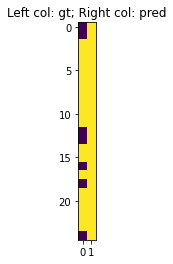

In [135]:
## VISUALIZE model output and parameters on test data

parameters_test = {
    "batch_size": 1,
    "shuffle": False,
}
test_set = thyroidDataset(split='test')
test_generator = torch.utils.data.DataLoader(test_set, **parameters_test)

predicted = []
ground_truth = []

attr_pred = []
attr_gt = []

count = 0
for data in test_generator:
    y_im_test = data["labels"][:, 15].to(device)
    x_im_test = data["image"]
    
    x_im_test = x_im_test.to(device)
    
    (y_pred, attributes_pred) = model(x_im_test)
    
    attr_pred.append(attributes_pred.detach().cpu().numpy())
    
    attr_gt.append(data["labels"][:, :15].detach().cpu().numpy())
    
    
    predicted.append(np.squeeze(y_pred.detach().cpu().numpy()))
    ground_truth.append(np.squeeze(y_im_test.detach().cpu().numpy()))
    count += 1
        
predicted = np.expand_dims(np.array(predicted), 1)
ground_truth = np.expand_dims(np.array(ground_truth), 1)
viz = (np.concatenate((ground_truth, predicted), axis=1)>0.5)*1

plt.imshow(viz)
plt.title("Left col: gt; Right col: pred")

err_perc = np.sum(np.abs(viz[:, 0] - viz[:, 1])) / np.size(viz[:, 0])
err_perc



In [46]:
np.shape(y_pred)

torch.Size([10, 1])

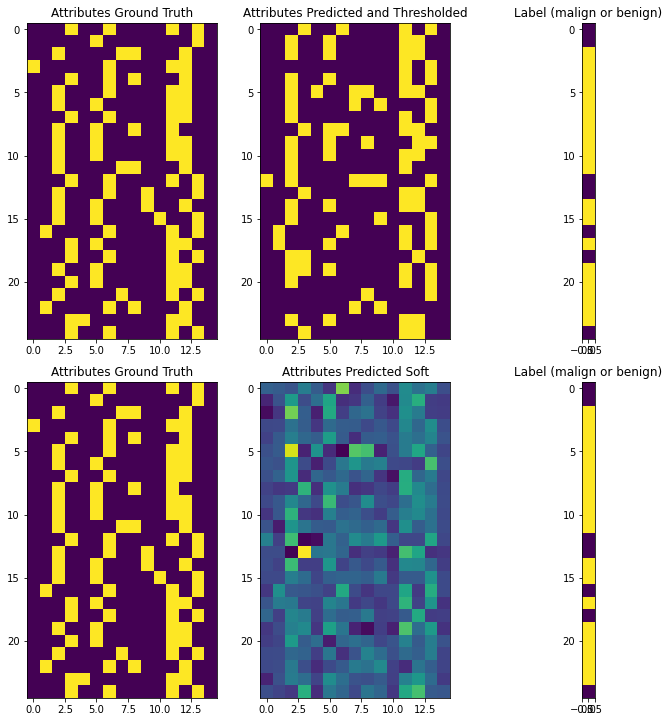

In [136]:
## ALL this should be on TEST set
attr_pred = np.squeeze(np.array(attr_pred))
attr_gt = np.squeeze(np.array(attr_gt))

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(231)    # The big subplot
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)


ax1.imshow(attr_gt)
ax1.set_title("Attributes Ground Truth")
ax2.imshow((attr_pred > 0.5) * 1)
ax2.set_title("Attributes Predicted and Thresholded")

ax3.imshow(np.expand_dims(viz[:, 0], 1))
ax3.set_title("Label (malign or benign)")

ax4.imshow(attr_gt)
ax4.set_title("Attributes Ground Truth")
ax5.imshow(attr_pred )
ax5.set_title("Attributes Predicted Soft")

ax6.imshow(np.expand_dims(viz[:, 0], 1))
ax6.set_title("Label (malign or benign)")


plt.tight_layout(pad=0.6, w_pad=0, h_pad=1.0)


Text(0.5, 0, 'Attribute probability')

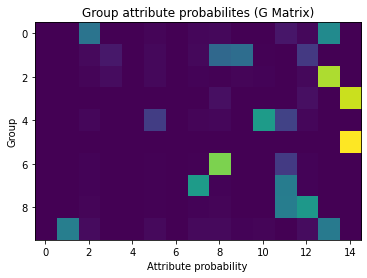

In [137]:
plt.imshow(model.G_.data.detach().cpu().numpy())
plt.title("Group attribute probabilites (G Matrix)")
plt.ylabel("Group")
plt.xlabel("Attribute probability")

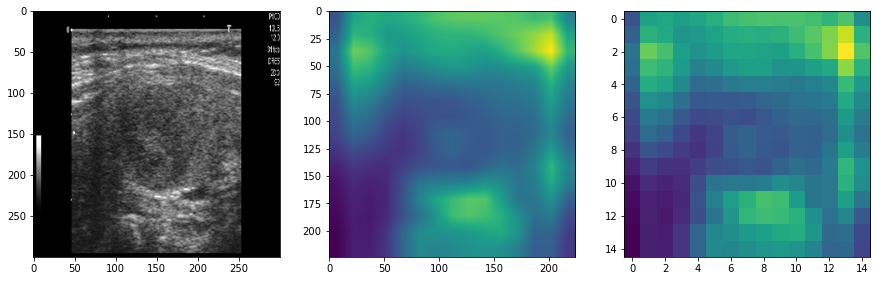

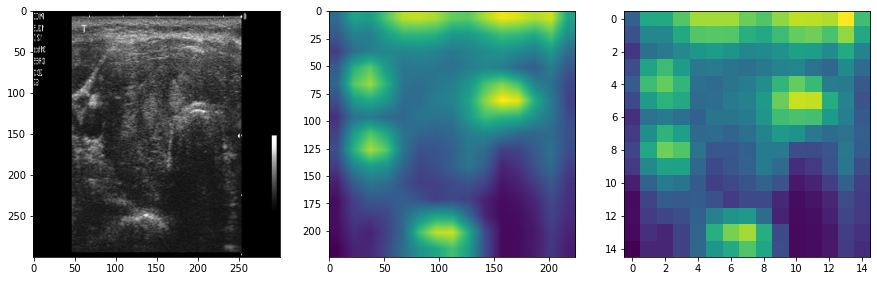

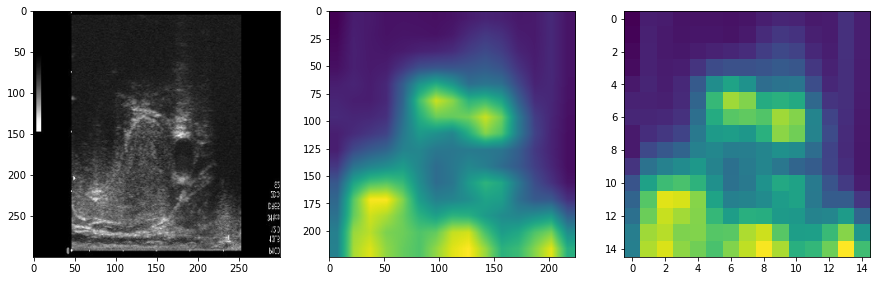

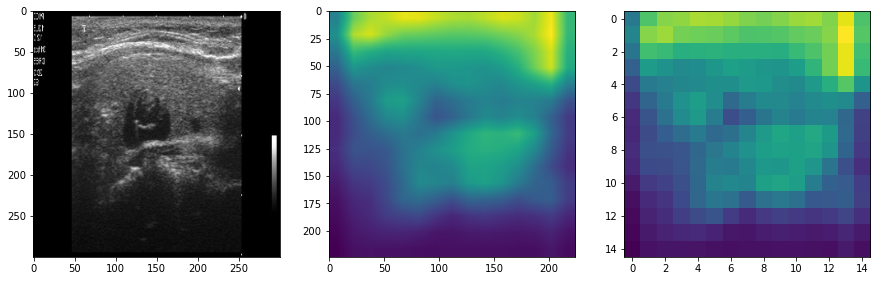

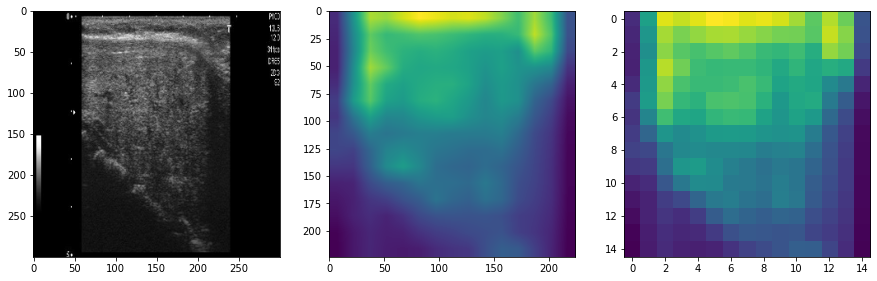

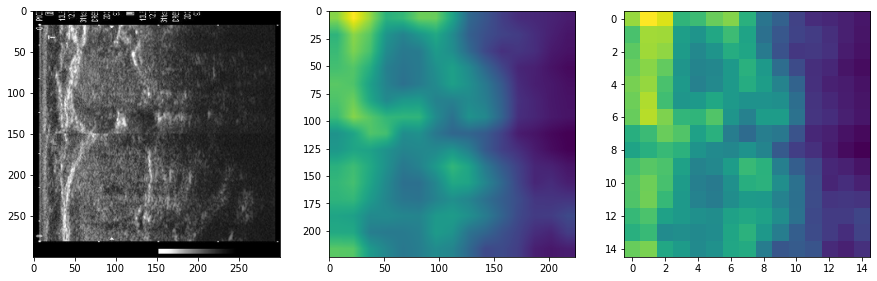

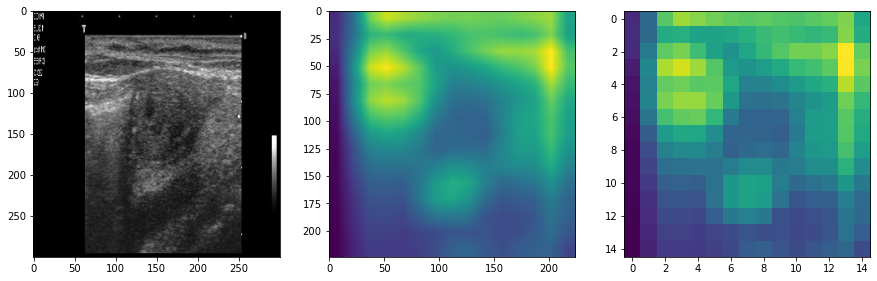

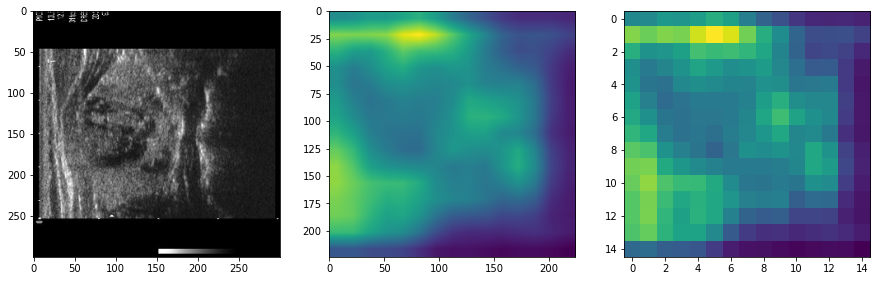

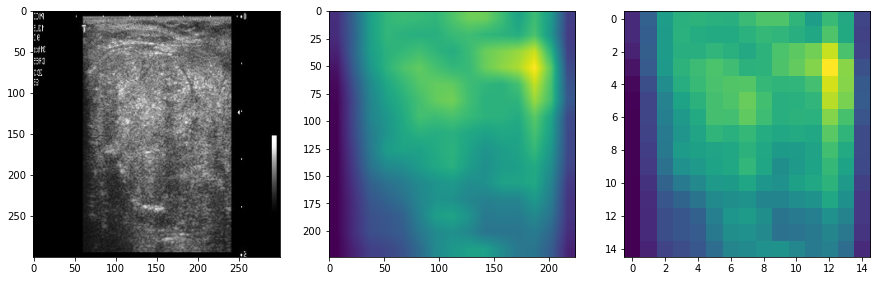

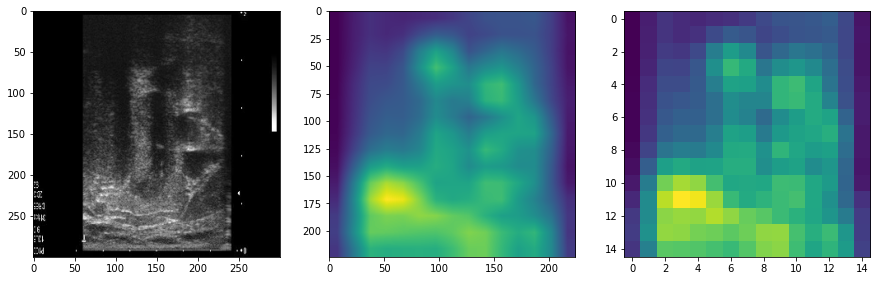

In [139]:

class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        module_pos = 1
        for module in self.model.features:
            x = model.pool(module(x))  # Forward
            if int(module_pos) == self.target_layer:
                conv_output = x  # Save the convolution output on that layer
            module_pos += 1
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        conv_output, _ = self.forward_pass_on_convolutions(x)
        x = F.interpolate(x, (300, 300), mode='bilinear')
        (x_, _) = model(x)
        return conv_output, x_

    
extractor = CamExtractor(model, 4)

count = 0
for data in test_generator:
    y_im_test = data["labels"][:, 15].to(device)
    x_im_test = data["image"]
    x_im_test = x_im_test.to(device)


    [conv_out, x] = extractor.forward_pass_on_convolutions(x_im_test)
    target = conv_out
    cam = np.ones((target.shape[1:]), dtype=np.float32)
    sal_map = np.zeros((224, 224))
    for i in range(np.shape(target)[1]):
                # Unsqueeze to 4D
                saliency_map = torch.unsqueeze(torch.unsqueeze(target[0, i, :, :],0),0)
                # Upsampling to input size
                saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
                if saliency_map.max() == saliency_map.min():
                    continue
                # Scale between 0-1
                norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
                inim = F.interpolate(x_im_test, size=(224, 224), mode='bilinear')
                w = extractor.forward_pass(inim * norm_saliency_map)[1]
                sal_map += w.cpu().data.numpy() * norm_saliency_map.cpu().data.numpy()[0, 0, :, :]
                cam += w.cpu().data.numpy() * target[0, i, :, :].cpu().data.numpy()


    fig = plt.figure(figsize=(15, 10))

    ax0 = fig.add_subplot(131)
    ax0.imshow(np.transpose(np.squeeze(x_im_test.cpu().detach().numpy()), (1, 2, 0)))

    ax1 = fig.add_subplot(132)
    ax1.imshow(sal_map)

    ax2 = fig.add_subplot(133)
    ax2.imshow(cam[0, :, :])
    count += 1
    if(count == 10):
        break


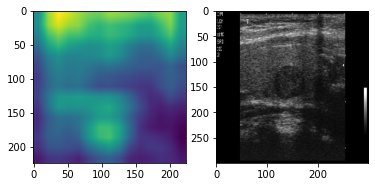

In [118]:
fig = plt.figure()
ax0 = fig.add_subplot(121)
ax0.imshow(sal_map)

ax1 = fig.add_subplot(122)
ax1.imshow(np.transpose(np.squeeze(x_im_test.cpu().detach().numpy()), (1, 2, 0)))



In [94]:
np.shape(target)[3]

15